In [1]:
from contextlib import redirect_stdout
import pandas as pd
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator

from matplotlib import font_manager
import matplotlib

In [2]:

matplotlib.get_cachedir()

'/home/niklas/.cache/matplotlib'

In [3]:
plt.rcParams.update({
    "font.family": "Helvetica",
    "axes.labelsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "legend.title_fontsize": 6,
})
ytick_fontsize = 6

In [4]:
path = "/mnt/z/Dasha/2. FAST-AB biosensors/Microscope/Sensors in Salmonella and macrophages/Macr-Salmonella_TMP_Doxy_Triton_Niklas.xlsx"

triton = {
    0: "Without Triton",
    2: "0.2 % Triton",
}
triton_order = [v for v in triton.values()]

def get_df(sheet_name):
    df = pd.read_excel(
    path,
    sheet_name=sheet_name,
    )

    for col in df.columns:
        if col == "Time, min":
            continue
        mi = df[col].min()
        ma = df[col].max()
        df[col] = (df[col] - mi) / (ma - mi)

    df = df.melt(id_vars="Time, min").dropna()

    df["split"] = df["variable"].str.split(" ")
    df["Antibiotic"] = df["split"].apply(lambda x: x[0])
    df["split2"] = df["split"].apply(lambda x: x[1]).str.split(".")
    df["Condition"] = df["split2"].apply(lambda x: triton[int(x[0])])
    df["Well"] = df["split2"].apply(lambda x: x[1])
    df["Position"] = df["split2"].apply(lambda x: x[2])
    
    return df

In [5]:
def get_control():
    df = pd.read_excel(path, sheet_name="Bacteria controls final")

    for col in df.columns:
        if col == "Time, min":
            continue
        mi = df[col].min()
        ma = df[col].max()
        df[col] = (df[col] - mi) / (ma - mi)

    df = df.melt(id_vars="Time, min").dropna()

    df["split"] = df["variable"].str.split(" ")
    df["Antibiotic"] = df["split"].apply(lambda x: x[0])
    df["split2"] = df["split"].apply(lambda x: x[1]).str.split(".")
    df["Condition"] = df["split2"].apply(lambda x: triton[int(x[0])])
    df["Well"] = df["split2"].apply(lambda x: x[1])
    df["Position"] = df["split2"].apply(lambda x: x[2])

    df["Macrophages"] = "Without"
    df["Time, min"] += 2
    
    return df

In [6]:
df = pd.concat([
    get_df(s) for s in ["Trimethoprim", "Doxycycline"]  # , "Tetracycline1", "Tetracycline2"]
], ignore_index=True)
df["Macrophages"] = "With"
df = pd.concat([df, get_control()], ignore_index=True)

In [7]:
df

,"Time, min",variable,value,split,Antibiotic,split2,Condition,Well,Position,Macrophages
0,0.000000,TMP 0.4.1,0.011594,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1,With
1,0.333333,TMP 0.4.1,0.012985,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1,With
2,0.666667,TMP 0.4.1,0.011063,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1,With
3,1.000000,TMP 0.4.1,0.006841,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1,With
4,1.333333,TMP 0.4.1,0.005578,"[TMP, 0.4.1]",TMP,"[0, 4, 1]",Without Triton,4,1,With
...,...,...,...,...,...,...,...,...,...,...
7108,60.500000,TMP 2.3.3,0.714062,"[TMP, 2.3.3]",TMP,"[2, 3, 3]",0.2 % Triton,3,3,Without
7109,61.000000,TMP 2.3.3,0.707744,"[TMP, 2.3.3]",TMP,"[2, 3, 3]",0.2 % Triton,3,3,Without
7110,61.500000,TMP 2.3.3,0.703562,"[TMP, 2.3.3]",TMP,"[2, 3, 3]",0.2 % Triton,3,3,Without
7111,62.000000,TMP 2.3.3,0.710055,"[TMP, 2.3.3]",TMP,"[2, 3, 3]",0.2 % Triton,3,3,Without


In [8]:
means = df.groupby([
    "Time, min", "Antibiotic", "Condition", "Macrophages", "Well", "Position"
])["value"].mean().reset_index()

In [9]:
inds = means["value"] > 0.5
time = "$T_{50}$ in min"
time = "T\u2085\u2080, min"
times = (means[inds].groupby([
    "Antibiotic", "Condition", "Macrophages", "Well", "Position"
])["Time, min"].min()-2).reset_index()
times = times.rename({"Time, min": time}, axis=1)

In [10]:
times

,Antibiotic,Condition,Macrophages,Well,Position,"T₅₀, min"
0,Doxy,0.2 % Triton,With,4,1,4.0
1,Doxy,0.2 % Triton,With,4,2,3.0
2,Doxy,0.2 % Triton,With,4,3,2.0
3,Doxy,0.2 % Triton,With,5,1,4.0
4,Doxy,0.2 % Triton,With,5,2,5.0
...,...,...,...,...,...,...
67,TMP,Without Triton,Without,2,2,4.0
68,TMP,Without Triton,Without,2,3,3.0
69,TMP,Without Triton,Without,3,1,3.0
70,TMP,Without Triton,Without,3,2,2.5


In [11]:
mean_times = times.groupby(["Antibiotic", "Condition", "Macrophages"])[time].mean()
mean_times.name = f"mean of {time}"
#mean_times.to_excel("/mnt/c/Users/niklas/Downloads/2025-08-07-Dasha-triton-means.xlsx")
mean_times

Antibiotic  Condition       Macrophages
Doxy        0.2 % Triton    With            3.777778
                            Without         2.722222
            Without Triton  With           13.666667
                            Without         2.777778
TMP         0.2 % Triton    With            0.888889
                            Without         3.000000
            Without Triton  With            1.185185
                            Without         3.055556
Name: mean of T₅₀, min, dtype: float64

In [12]:
stds_times = times.groupby(["Antibiotic", "Condition", "Macrophages"])[time].std()
stds_times.name = f"std of {time}"
#stds_times.to_excel("/mnt/c/Users/niklas/Downloads/2025-08-07-Dasha-triton-stds.xlsx")
stds_times

Antibiotic  Condition       Macrophages
Doxy        0.2 % Triton    With           0.971825
                            Without        0.263523
            Without Triton  With           1.870829
                            Without        0.263523
TMP         0.2 % Triton    With           0.500000
                            Without        0.353553
            Without Triton  With           0.175682
                            Without        0.390868
Name: std of T₅₀, min, dtype: float64

In [13]:
pd.concat([mean_times, stds_times], axis=1).to_excel("/mnt/c/Users/niklas/Downloads/2025-08-07-Dasha-triton-times.xlsx")

<Figure size 1800x2400 with 0 Axes>

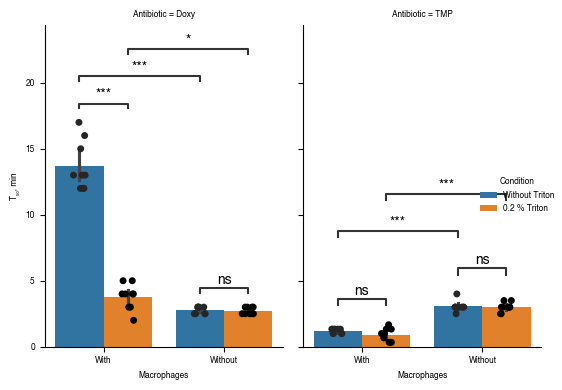

In [14]:
x = "Macrophages"
col = "Antibiotic"
hue = "Condition"
order = ["Tet", "Doxy", "TMP"]
order = ["With", "Without"]
col_order = ["Doxy", "TMP"]

plt.figure(dpi=600, figsize=[3, 4])


fg = sns.catplot(
    times,
    x=x,
    y=time,
    hue=hue,
    order=order,
    hue_order=triton_order,
    col=col,
    col_order=col_order,
    kind="bar",
    height=4,
    aspect=.6,
)

fg.map(
    sns.stripplot,
    x,
    time,
    hue,
    dodge=True,
    palette='dark:black',
    order=order,
    hue_order=triton_order,
    legend=False,
)

for i, abx in enumerate(col_order):
    ax = fg.axes[0, i]
    
    pairs=[

        (("With", triton[0]), ("Without", triton[0])),
        (("With", triton[2]), ("Without", triton[2])),
        
        (("With", triton[0]), ("With", triton[2])),
        (("Without", triton[0]), ("Without", triton[2])),
        
        #(("Tet", triton[0]), ("Tet", triton[2])),
        #(("Doxy", triton[0]), ("Doxy", triton[2])),
        #(("TMP", triton[0]), ("TMP", triton[2])),
        
        #(("TMP", triton[0]), ("Doxy", triton[0])),
        #(("TMP", triton[2]), ("Doxy", triton[2])),
        
        #(("Tet", triton[0]), ("Doxy", triton[0])),
        #(("Tet", triton[2]), ("Doxy", triton[2])),
        
        #(("TMP", triton[0]), ("Tet", triton[0])),
        #(("TMP", triton[2]), ("Tet", triton[2])),
    ]

    tmp_times = times[times[col] == abx]
    annotator = Annotator(ax, pairs, data=tmp_times, x=x, y=time, hue=hue, order=order, hue_order=triton_order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    
    with open("/mnt/c/Users/niklas/Downloads/2025-08-07-Dasha-triton-pvalues.txt", 'a') as f:
        with redirect_stdout(f):
            print("*** ", abx, " ***")
            annotator.apply_and_annotate()
            print("\n")

    #ax.set_xlabel("")
    #if i == 0:
     #   ax.legend().set_title(None)
    
    ytick_font = font_manager.FontProperties(family="Helvetica Neue", size=ytick_fontsize)
    
    # Anwenden auf yticks
    for label in ax.get_yticklabels():
        label.set_fontproperties(ytick_font)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-08-07-Dasha-triton.pdf")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TMP_0.2 % Triton vs. TMP_Without Triton: Mann-Whitney-Wilcoxon test two-sided, P_val:6.264e-01 U_stat=1.465e+02
Doxy_0.2 % Triton vs. Doxy_Without Triton: Mann-Whitney-Wilcoxon test two-sided, P_val:5.807e-02 U_stat=1.030e+02


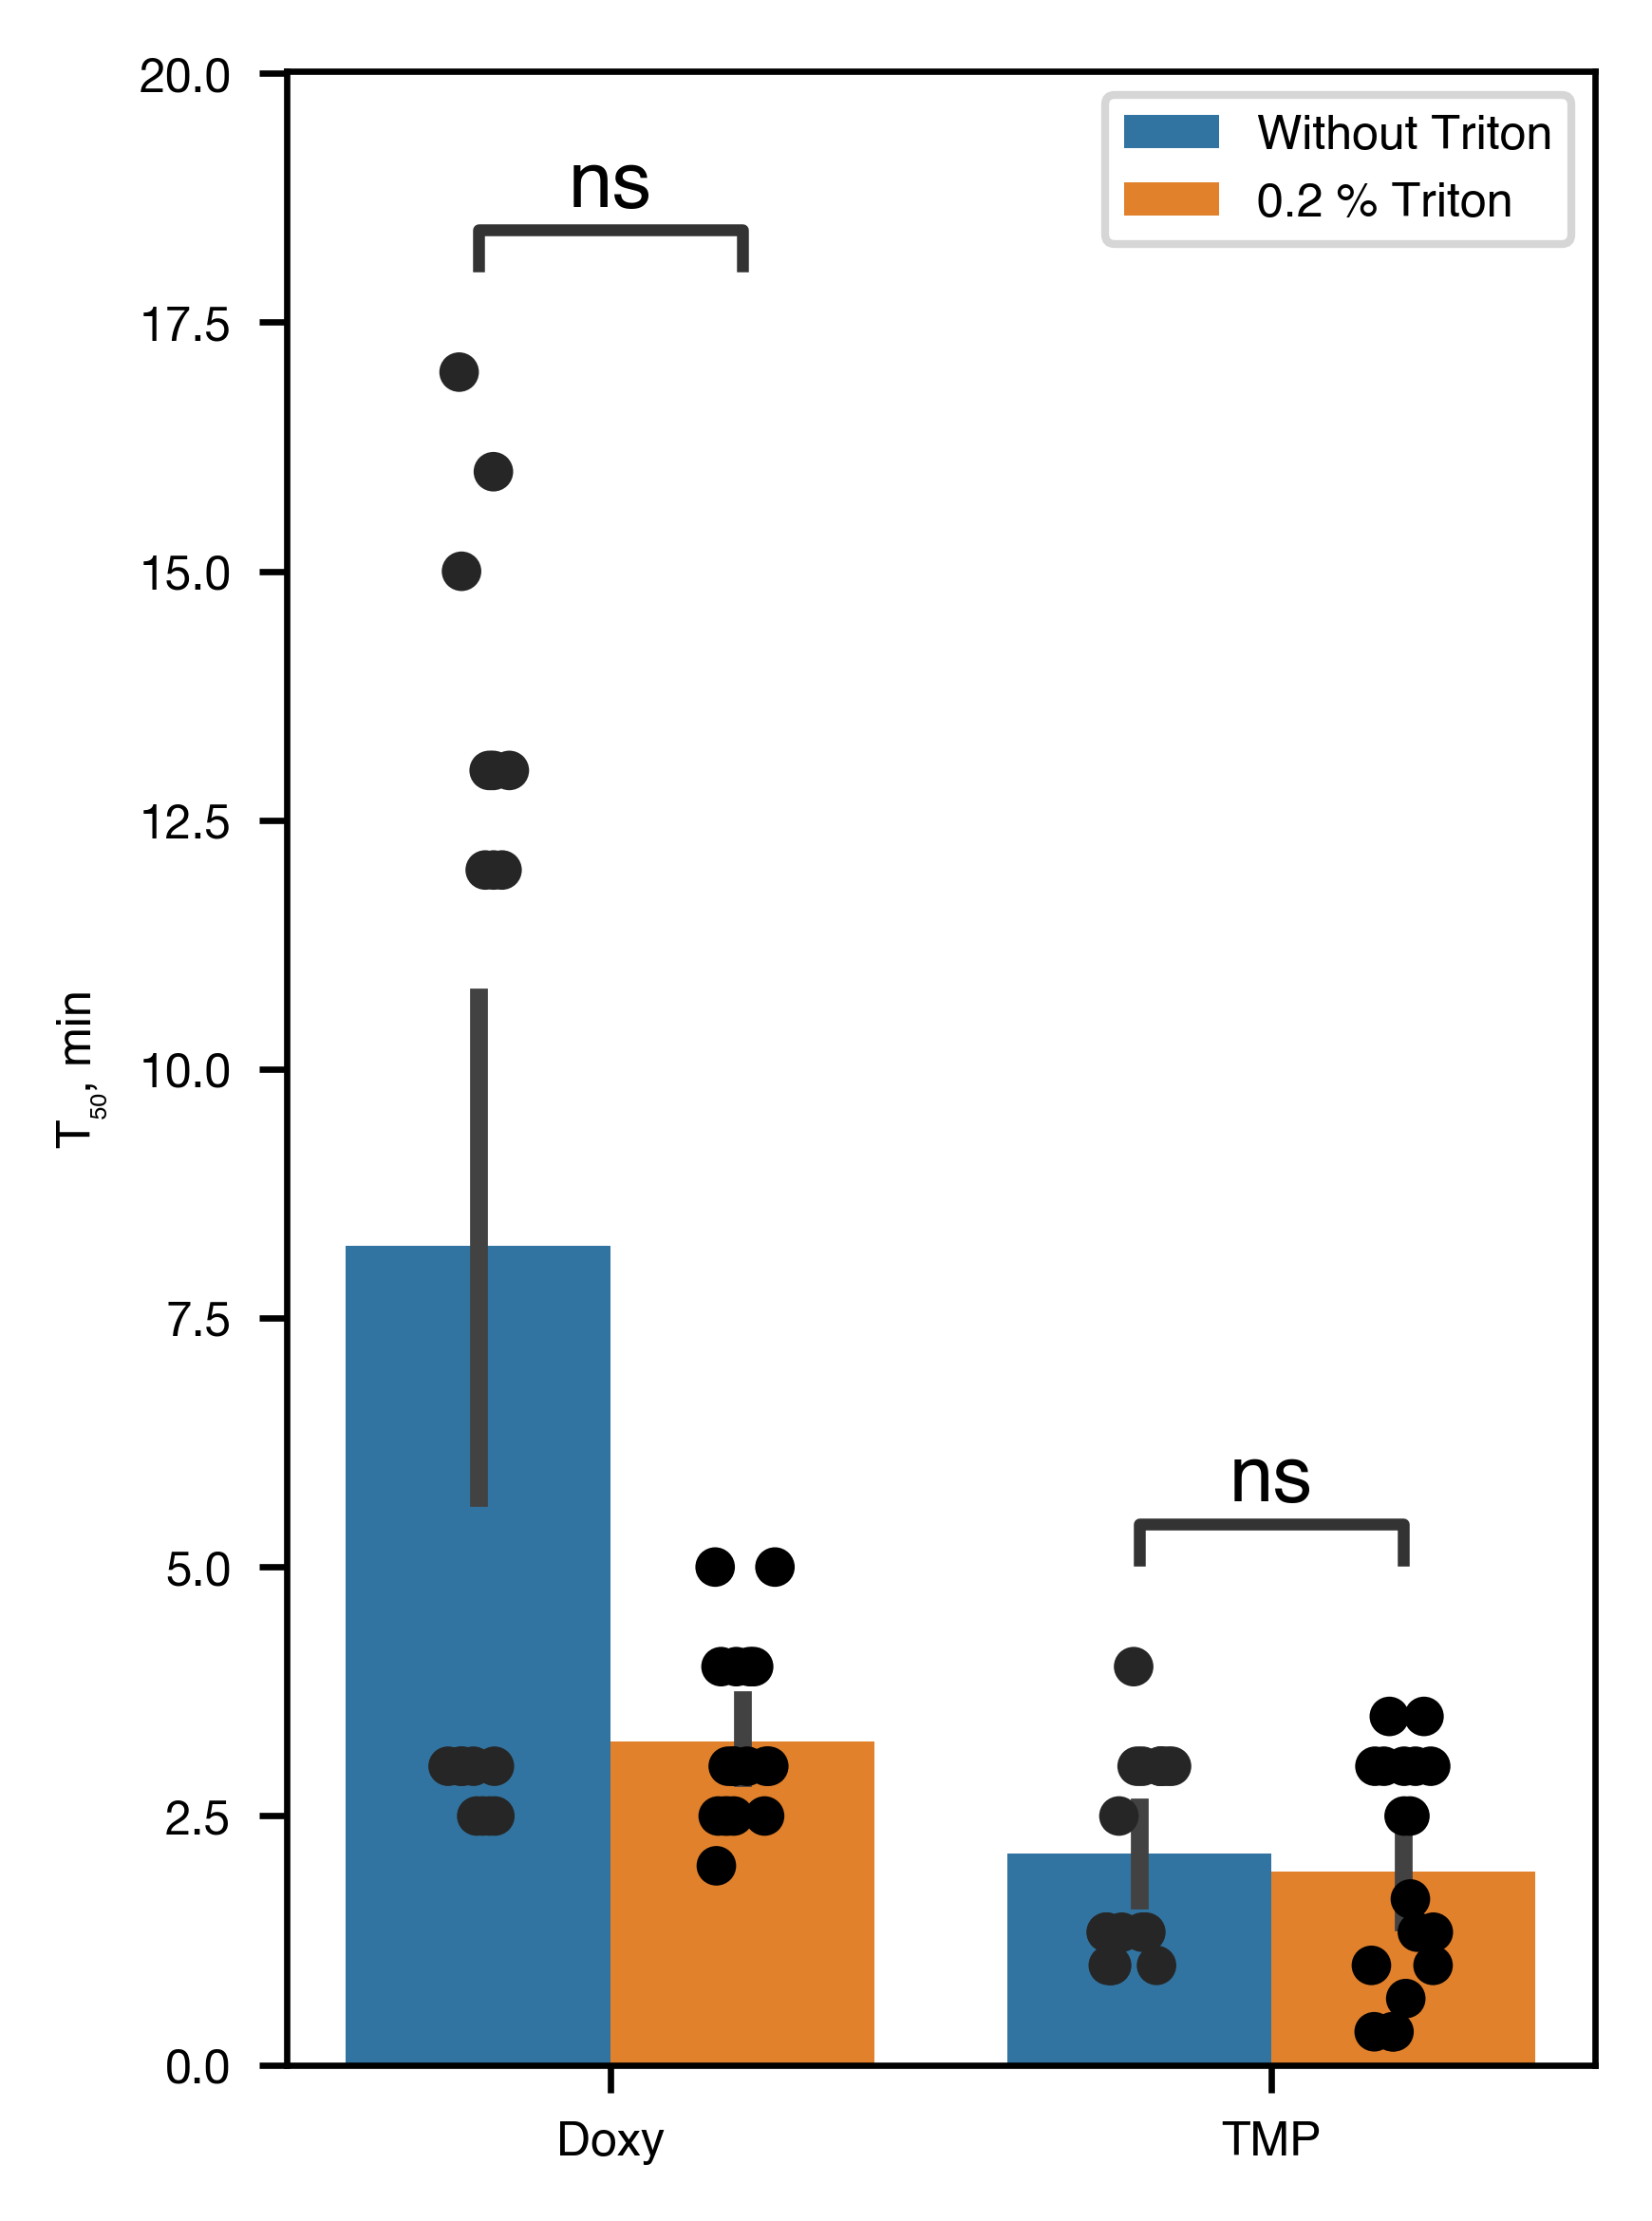

In [15]:
x = "Antibiotic"
hue = "Condition"
order = ["Tet", "Doxy", "TMP"]
order = ["Doxy", "TMP"]

plt.figure(dpi=600, figsize=[3, 4])


sns.barplot(
    times,
    x=x,
    y=time,
    hue=hue,
    order=order,
    hue_order=triton_order,
)
ax = sns.stripplot(
    times,
    x=x,
    y=time,
    hue=hue,
    dodge=True,
    palette='dark:black',
    legend=False,
    order=order,
    hue_order=triton_order,
)

pairs=[
    #(("Tet", triton[0]), ("Tet", triton[2])),
    (("Doxy", triton[0]), ("Doxy", triton[2])),
    (("TMP", triton[0]), ("TMP", triton[2])),
    
    #(("TMP", triton[0]), ("Doxy", triton[0])),
    #(("TMP", triton[2]), ("Doxy", triton[2])),
    
    #(("Tet", triton[0]), ("Doxy", triton[0])),
    #(("Tet", triton[2]), ("Doxy", triton[2])),
    
    #(("TMP", triton[0]), ("Tet", triton[0])),
    #(("TMP", triton[2]), ("Tet", triton[2])),
]

annotator = Annotator(ax, pairs, data=times, x=x, y=time, hue=hue, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_xlabel("")
ax.legend().set_title(None)

ytick_font = font_manager.FontProperties(family="Helvetica Neue", size=ytick_fontsize)

# Anwenden auf yticks
for label in ax.get_yticklabels():
    label.set_fontproperties(ytick_font)

plt.tight_layout()
#plt.savefig("/mnt/c/Users/niklas/Downloads/2025-04-22-Dasha-triton.pdf")

In [16]:
text_obj = ax.set_title("test")

In [73]:
fg.axes[0, 0].set_title("")

Text(0.5, 1.0, '')

In [ ]:
x = "Macrophages"
col = "Antibiotic"
hue = "Condition"
order = ["Tet", "Doxy", "TMP"]
order = ["With", "Without"]
col_order = ["Doxy", "TMP"]

plt.figure(dpi=600, figsize=[3, 4])


sns.catplot(
    times,
    x=x,
    y=time,
    hue=hue,
    order=order,
    hue_order=triton_order,
    col=col,
    col_order=col_order,
    kind="bar",
)
ax = sns.stripplot(
    times,
    x=x,
    y=time,
    hue=hue,
    dodge=True,
    palette='dark:black',
    legend=False,
    order=order,
    hue_order=triton_order,
)

pairs=[
    #(("Tet", triton[0]), ("Tet", triton[2])),
    (("Doxy", triton[0]), ("Doxy", triton[2])),
    (("TMP", triton[0]), ("TMP", triton[2])),
    
    #(("TMP", triton[0]), ("Doxy", triton[0])),
    #(("TMP", triton[2]), ("Doxy", triton[2])),
    
    #(("Tet", triton[0]), ("Doxy", triton[0])),
    #(("Tet", triton[2]), ("Doxy", triton[2])),
    
    #(("TMP", triton[0]), ("Tet", triton[0])),
    #(("TMP", triton[2]), ("Tet", triton[2])),
]

annotator = Annotator(ax, pairs, data=times, x=x, y=time, hue=hue, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_xlabel("")
ax.legend().set_title(None)

ytick_font = font_manager.FontProperties(family="Helvetica Neue", size=ytick_fontsize)

# Anwenden auf yticks
for label in ax.get_yticklabels():
    label.set_fontproperties(ytick_font)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-04-22-Dasha-triton.pdf")

In [37]:
fontname = text_obj.get_fontproperties().get_name()
fontfile = font_manager.findfont(text_obj.get_fontproperties())

fontfile

'/home/niklas/.fonts/HelveticaNeue-Regular.ttf'

KeyboardInterrupt: 

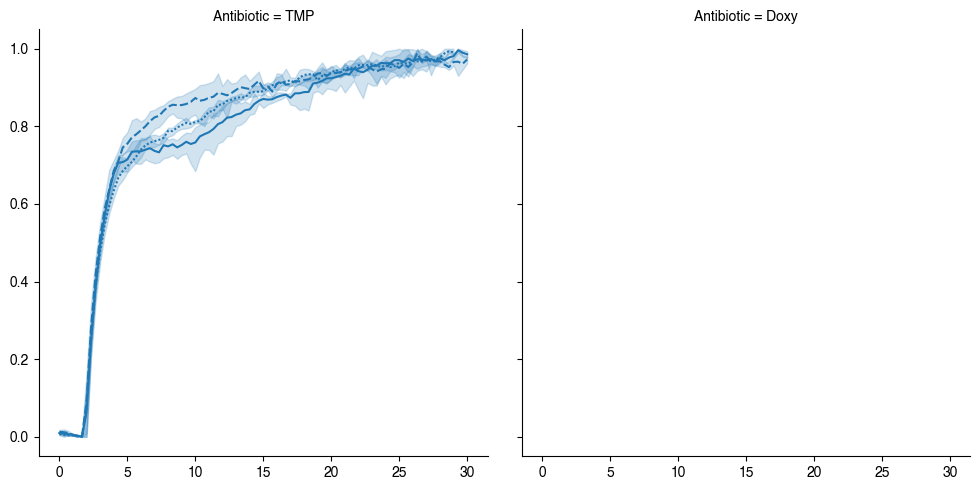

In [39]:
sns.relplot(
    df,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
)

In [ ]:
sns.relplot(
    df,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

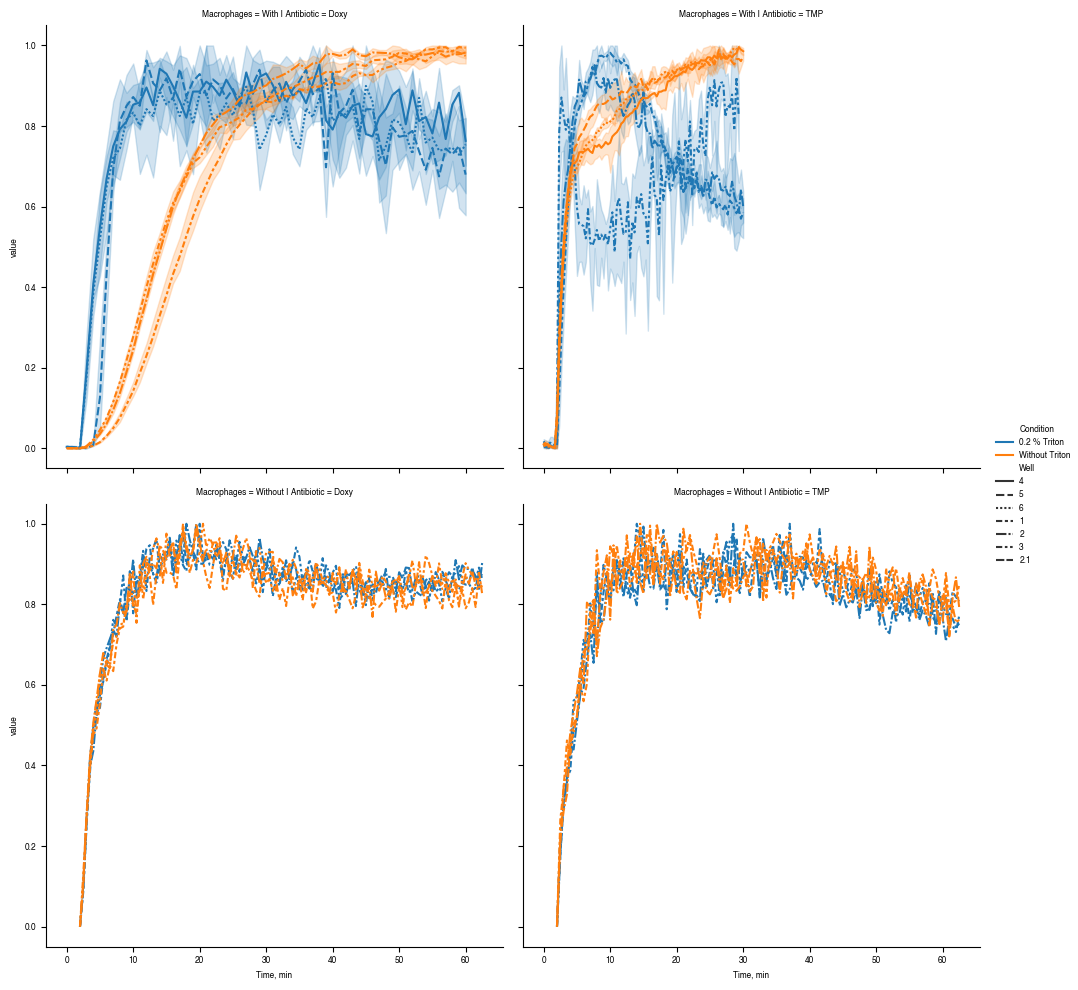

In [86]:
sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    row="Macrophages",
    kind="line",
)

<Figure size 3000x2400 with 0 Axes>

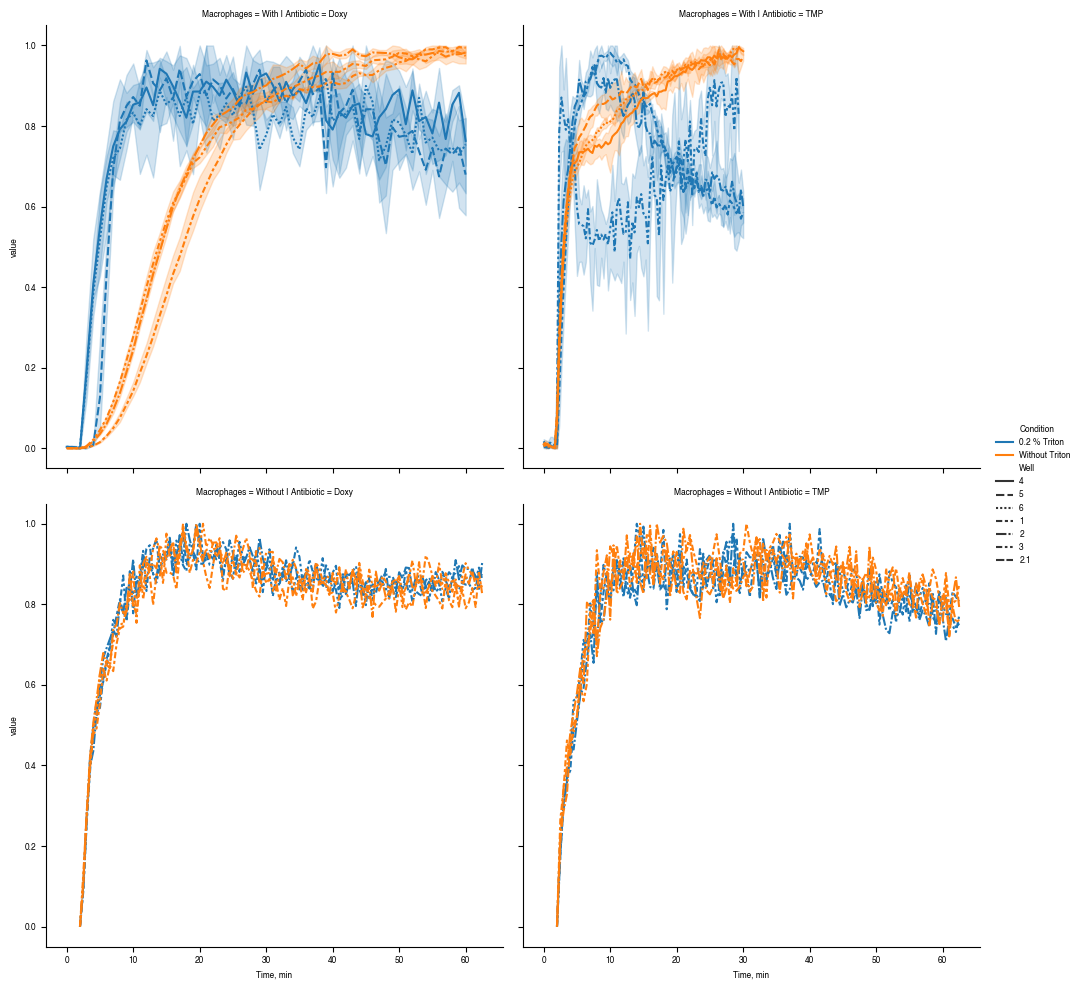

In [87]:
plt.figure(dpi=600, figsize=[5, 4])

sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    row="Macrophages",
    kind="line",
)

<Figure size 3000x2400 with 0 Axes>

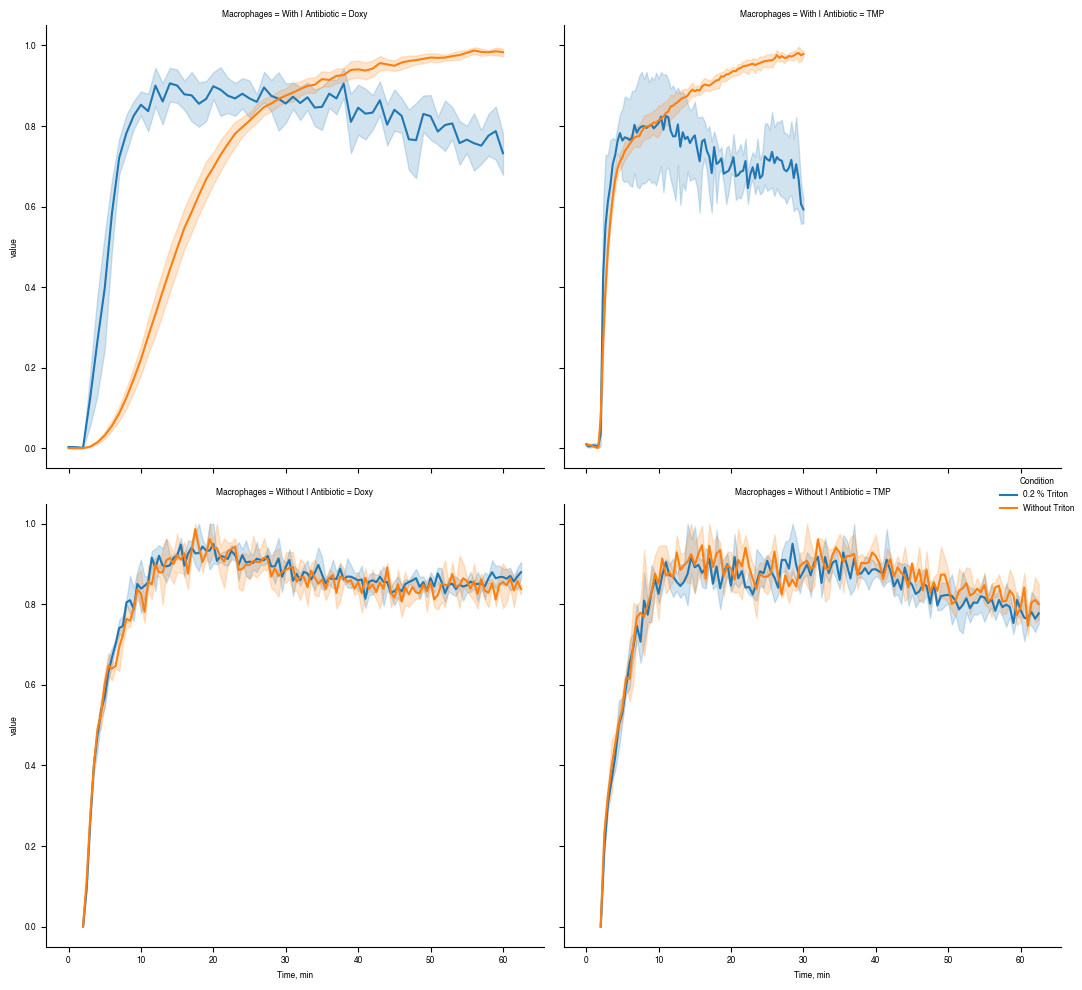

In [89]:
plt.figure(dpi=600, figsize=[5, 4])

sns.relplot(
    means,
    x="Time, min",
    y="value",
    hue="Condition",
    #style="Well",
    col="Antibiotic",
    row="Macrophages",
    kind="line",
)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-07-25-Dasha-triton-curves.pdf")

<Figure size 3000x2400 with 0 Axes>

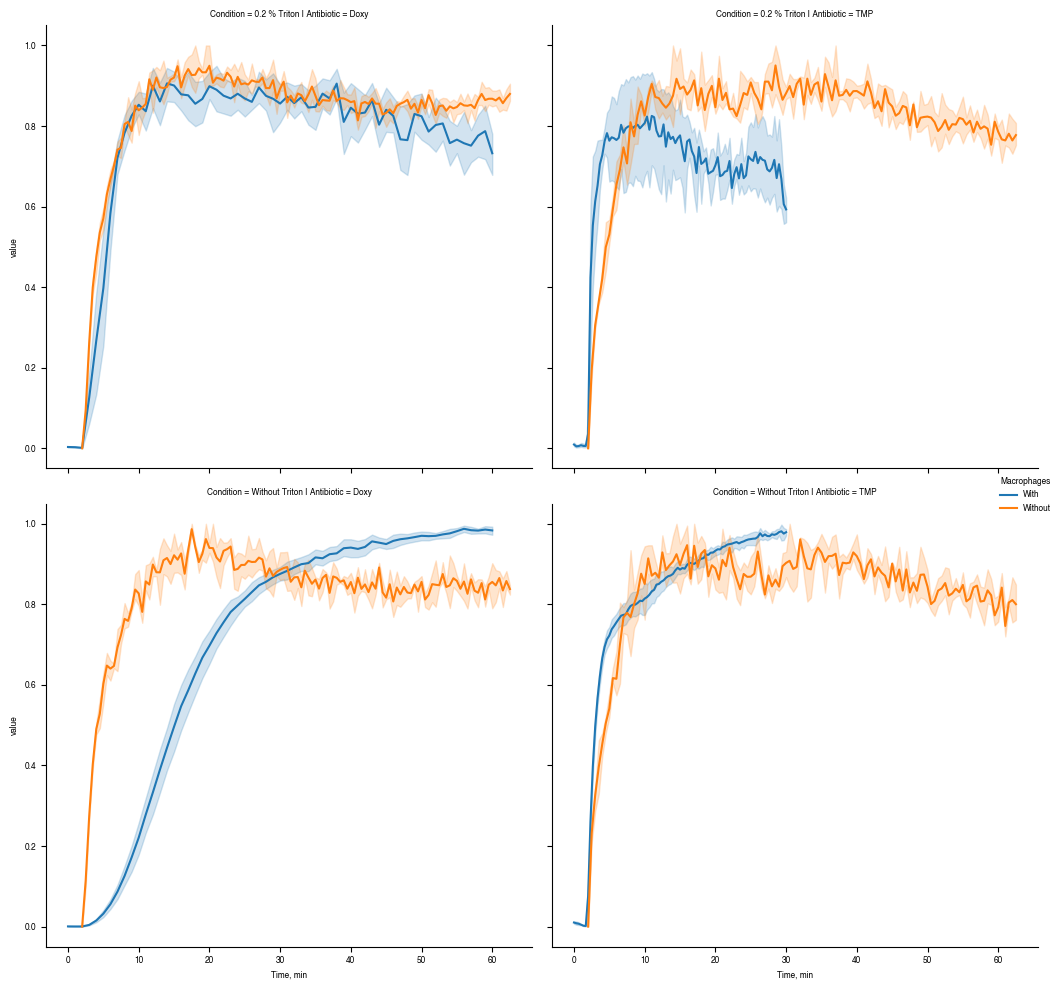

In [90]:
plt.figure(dpi=600, figsize=[5, 4])

sns.relplot(
    means,
    x="Time, min",
    y="value",
    row="Condition",
    #style="Well",
    col="Antibiotic",
    hue="Macrophages",
    kind="line",
)

plt.tight_layout()
plt.savefig("/mnt/c/Users/niklas/Downloads/2025-07-25-Dasha-triton-curves2.pdf")

<AxesSubplot: xlabel='Time, min', ylabel='value'>

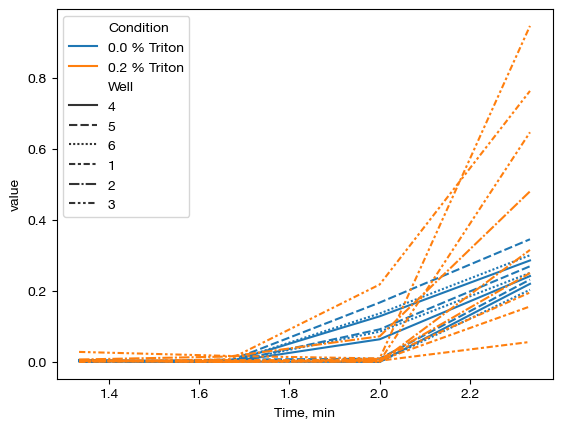

In [16]:
sns.lineplot(
    df[(df["Time, min"]>1) & (df["Time, min"]<2.5)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    units="Position",
    estimator=None,
)

In [ ]:
sns.relplot(
    df[(df["Time, min"]>1) & (df["Time, min"]<2.5)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

In [ ]:
sns.relplot(
    df[(df["Time, min"]<10)],
    x="Time, min",
    y="value",
    hue="Condition",
    style="Well",
    col="Antibiotic",
    kind="line",
    units="Position",
    estimator=None,
)

In [18]:
print(font_manager.findSystemFonts())

['/usr/share/fonts/truetype/lato/Lato-Italic.ttf', '/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', '/usr/share/fonts/truetype/lato/Lato-Black.ttf', '/home/niklas/.fonts/Helvetica#1.ttf', '/usr/share/fonts/truetype/lato/Lato-ThinItalic.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/lato/Lato-Regular.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', '/home/niklas/.fonts/Helvetica#4.ttf', '/usr/share/fonts/truetype/lato/Lato-Thin.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf', '/home/niklas/.fonts/Helvetica#3.ttf', '/usr/share/fonts/truetype/lato/Lato-HairlineItalic.ttf', '/usr/shar

In [23]:
for font in font_manager.fontManager.ttflist:
    print(f"{font.name} ({font.fname})")
    print(font)

STIXGeneral (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')
DejaVu Sans (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
STIXSizeTwoSym (/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf)
FontEntry(fname='/home/niklas/miniconda3/envs/vis/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', v